# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
# -------------------------------------------------
# First, we load all the data from the NotMNIST dataset
# -------------------------------------------------
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import cv2
import math
import random
    
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)
  
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
# -------------------------------------------------

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


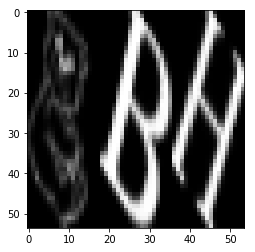

[ 1.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.]
[ 0.  0.  1.  0.  0.]
[ 0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  1.]


In [2]:
# -------------------------------------------------
# Let's define some helpful functions
# -------------------------------------------------
    
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def oneHot(num, length):
    arr = np.zeros(length)
    arr[num-1]=1.0
    return arr

newSize=32
imgSize=54


# -------------------------------------------------
# Then, let's define the functions for returning scale, crop and rotation variants for each image
# -------------------------------------------------
# input is x by y array
def rotate(pixels, newSize, angle):
    size = pixels.shape[0]
    newPixels = np.full([newSize, newSize], -0.5)
    startPos = (newSize-size)//2
    for i in range(0,size):
        for j in range(0,size):
            newPixels[startPos+i][startPos+j] = pixels[i][j]
    newPixels = newPixels + 0.5
    cols = newSize
    rows = newSize
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle, 1)
    rotated = cv2.warpAffine(newPixels,M,(cols,rows))
    rotated = rotated - 0.5
    return rotated        

def translate(image, widthTranslate, heightTranslate):
    newPixels = image+0.5
    M = np.float32([[1,0,widthTranslate],[0,1,heightTranslate]])
    newPixels = cv2.warpAffine(newPixels,M,(image.shape[1],image.shape[0]))
    return newPixels-0.5

# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
# def correct(image):
#     newPixels = image+0.5
# #     kernel_sharpen_1 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# #     newPixels = cv2.filter2D(newPixels, -1, kernel_sharpen_1)
#     newPixels = cv2.equalizeHist(newPixels)    
#     return newPixels-0.5

def getVariant(digits, toSize):
    angles = [330, 345,0,15,30]
    angle = random.choice(angles)
    numberOfDigits = digits.shape[0]
    variant=np.full([newSize, newSize*numberOfDigits], -0.5) 
    for num, digit in enumerate(digits):
        digit=rotate(digit, newSize, angle)
        for i in range(0,newSize):
            for j in range(0,newSize):
                if(digit[i][j]>-0.5):
                    variant[i][(num*newSize)+j] = digit[i][j]    
    #variant = translate(variant, random.randint(-5,5), random.randint(-5,5))
    variant = cv2.resize(variant, (toSize, toSize)) 
    return variant

import random
    
#We make the function to get some variants of the image & test it
sampleImage1=train_dataset[random.randint(0,train_dataset.shape[0])]
sampleImage1=np.reshape(sampleImage1, [28, 28])
sampleImage2=train_dataset[random.randint(0,train_dataset.shape[0])]
sampleImage2=np.reshape(sampleImage2, [28, 28])
sampleImage3=train_dataset[random.randint(0,train_dataset.shape[0])]
sampleImage3=np.reshape(sampleImage3, [28, 28])

digits = np.ndarray([3,28,28])
digits[0] = np.copy(sampleImage1)
digits[1] = np.copy(sampleImage2)
digits[2] = np.copy(sampleImage3)
variant = getVariant(digits, imgSize)
plt.imshow(variant, cmap='gray')
plt.show()

for i in range(0,5):
    print(oneHot(i+1,5))

In [4]:
#Let's build the new training set
train_size=50000
valid_size=12000

import random
def createDataset(originalDataSet,dataSize,sizeOfDigitsFromOriginal):
    newDataset=np.ndarray([dataSize,imgSize*imgSize])
    lengthLabels=np.ndarray([dataSize,5])
    digitsLabels = np.zeros([dataSize,5,10])
    for i in range(0, dataSize):
        numberOfDigits=random.randint(1,5)
        digits = np.ndarray([5,28,28])
        for j in range(0, 5):
            index=random.randint(0,sizeOfDigitsFromOriginal);
            randImage=train_dataset[index]
            randImage=np.reshape(randImage, [28, 28])
            digits[j] = np.copy(randImage)
            if j < numberOfDigits:
                digitsLabels[i][j][0:10]=train_labels[index]
            #    digitsLabels[i][j][0:10]=train_labels[index]
            #else:
            #    digitsLabels[i][j][10] = 1
            
        
        #print(digitsLabels[i])
        variant = getVariant(digits, imgSize)
#         plt.imshow(variant, cmap='gray')
#         plt.show()
        
        newDataset[i]=variant.reshape((imgSize*imgSize))
        lengthLabels[i]=oneHot(numberOfDigits,5)
        #print(lengthLabels[i])
        if (i % 500 == 0):
            print('Completed %d of %d' % (i, dataSize))
    return newDataset, lengthLabels, digitsLabels
import os.path
import pickle

def maybeLoadData(dataset, size, pickleFile):
    import os.path
    import pickle
    file_path=pickleFile + '.pk'
    if(os.path.exists(file_path) is False):
        imageData, imageLengths, imageDigits = createDataset(dataset, size, dataset.shape[0]//100)
        data = { 'imageData': imageData, 'imageLengths': imageLengths, 'imageDigits': imageDigits}
        pickle.dump(data , open( file_path, "wb" ))
        imageData=imageData.astype(np.float32)
        imageLengths=imageLengths.astype(np.float32)
        
    data = pickle.load( open( file_path, "rb" ) );
    return data['imageData'], data['imageLengths'], data['imageDigits']

print('Creating new Train data from about 2000 digits')
newTrainData, newTrainLengths, newTrainDigitLabels = maybeLoadData(train_dataset,train_size, 'synth_train')
print("Training data images: {}".format(newTrainData.shape))
print("              length: {}".format(newTrainLengths.shape))
print("              digits: {}".format(newTrainDigitLabels.shape))


print('Creating new Validation data from about 100 digits')
newValidationData, newValidationLengths, newValidationDigitLabels = maybeLoadData(valid_dataset,valid_size, 'synth_val')
print("Test & Validation data images: {}".format(newValidationData.shape))
print("                length: {}".format(newValidationLengths.shape))    
print("                digits: {}".format(newValidationDigitLabels.shape))


Creating new Train data from about 2000 digits
Completed 0 of 50000
Completed 500 of 50000
Completed 1000 of 50000
Completed 1500 of 50000
Completed 2000 of 50000
Completed 2500 of 50000
Completed 3000 of 50000
Completed 3500 of 50000
Completed 4000 of 50000
Completed 4500 of 50000
Completed 5000 of 50000
Completed 5500 of 50000
Completed 6000 of 50000
Completed 6500 of 50000
Completed 7000 of 50000
Completed 7500 of 50000
Completed 8000 of 50000
Completed 8500 of 50000
Completed 9000 of 50000
Completed 9500 of 50000
Completed 10000 of 50000
Completed 10500 of 50000
Completed 11000 of 50000
Completed 11500 of 50000
Completed 12000 of 50000
Completed 12500 of 50000
Completed 13000 of 50000
Completed 13500 of 50000
Completed 14000 of 50000
Completed 14500 of 50000
Completed 15000 of 50000
Completed 15500 of 50000
Completed 16000 of 50000
Completed 16500 of 50000
Completed 17000 of 50000
Completed 17500 of 50000
Completed 18000 of 50000
Completed 18500 of 50000
Completed 19000 of 50000
Co

In [ ]:
#Deep Neural Network Model
batch_size = 150
image_size=imgSize*imgSize
layer1_size = imgSize*imgSize//4
layer2_size = 256
layer3_size = 32
num_labels=5
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(None, image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  tf_valid_dataset = tf.constant(newValidationData)
  tf_test_dataset = tf.constant(newTestData)
  
  # Variables.
  weights1 = tf.get_variable('W1', shape=[image_size, layer1_size], initializer=tf.contrib.layers.xavier_initializer()) 
  biases1 = tf.Variable(tf.zeros([layer1_size]))
    
  weights2 = tf.get_variable('W2', shape=[layer1_size, layer2_size], initializer=tf.contrib.layers.xavier_initializer()) 
  biases2 = tf.Variable(tf.zeros([layer2_size]))
    
  weights3 = tf.get_variable('W3', shape=[layer2_size, layer3_size], initializer=tf.contrib.layers.xavier_initializer()) 
  biases3 = tf.Variable(tf.zeros([layer3_size]))
    
  weights4 = tf.get_variable('W4', shape=[layer3_size, num_labels], initializer=tf.contrib.layers.xavier_initializer()) 
  biases4 = tf.Variable(tf.zeros([num_labels]))
    
  def model(data):
      logits1 = tf.matmul(data, weights1) + biases1
      relu1 = tf.nn.relu6(logits1)
      logits2 = tf.matmul(relu1, weights2) + biases2
      relu2 =tf.nn.relu6(logits2)
      logits3 = tf.matmul(relu2, weights3) + biases3
      relu3 =tf.nn.relu6(logits3)
      logits4 = tf.matmul(relu3, weights4) + biases4
      return logits4
    
  # Training computation.
  logits = model(tf_train_dataset)
  loss1 = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  l2Loss = loss1 + ((tf.nn.l2_loss(weights1)+ tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4))/(2*batch_size))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(l2Loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

num_steps = 15001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (newTrainLength.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = newTrainData[offset:(offset + batch_size), :]
        batch_labels = newTrainLength[offset:(offset + batch_size), :]

        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, l2Loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), newValidationLength))
    predicted_test=test_prediction.eval();
    print('Test accuracy: %.1f%%' % accuracy(predicted_test, newTestLength))


In [ ]:
# #Deep Neural Network Model
# batch_size = 50
# image_size=newSize*newSize*5
# layer1_size = newSize*10
# layer2_size = 256
# layer3_size = 32
# num_labels=5
# graph = tf.Graph()
# with graph.as_default():

#   # Input data. For the training data, we use a placeholder that will be fed
#   # at run time with a training minibatch.
#   tf_train_dataset = tf.placeholder(tf.float32,
#                                     shape=(None, image_size))
#   tf_train_length = tf.placeholder(tf.float32, shape=(None, num_labels))
#   tf_train_digits = tf.placeholder(tf.float32, shape=(None, num_labels * 10))
#   tf_train_allhot = tf.placeholder(tf.float32, shape=(None, num_labels))
#   tf_valid_dataset = tf.constant(newValidationData)
#   tf_test_dataset = tf.constant(newTestData)
  
#   # Variables.
#   weights1 = tf.get_variable('W1', shape=[image_size, layer1_size], initializer=tf.contrib.layers.xavier_initializer()) 
#   biases1 = tf.Variable(tf.zeros([layer1_size]))
    
#   weights2 = tf.get_variable('W2', shape=[layer1_size, layer2_size], initializer=tf.contrib.layers.xavier_initializer()) 
#   biases2 = tf.Variable(tf.zeros([layer2_size]))
    
#   weights3 = tf.get_variable('W3', shape=[layer2_size, layer3_size], initializer=tf.contrib.layers.xavier_initializer()) 
#   biases3 = tf.Variable(tf.zeros([layer3_size]))
    
#   weights4 = tf.get_variable('W4', shape=[layer3_size, num_labels], initializer=tf.contrib.layers.xavier_initializer()) 
#   biases4 = tf.Variable(tf.zeros([num_labels]))
    
#   weights_d0 = tf.get_variable('W_d0', shape=[layer3_size, 10], initializer=tf.contrib.layers.xavier_initializer()) 
#   biases_d0 = tf.Variable(tf.zeros([10]))
#   weights_d1 = tf.get_variable('W_d1', shape=[layer3_size, 10], initializer=tf.contrib.layers.xavier_initializer()) 
#   biases_d1 = tf.Variable(tf.zeros([10]))
#   weights_d2 = tf.get_variable('W_d2', shape=[layer3_size, 10], initializer=tf.contrib.layers.xavier_initializer()) 
#   biases_d2 = tf.Variable(tf.zeros([10]))
#   weights_d3 = tf.get_variable('W_d3', shape=[layer3_size, 10], initializer=tf.contrib.layers.xavier_initializer()) 
#   biases_d3 = tf.Variable(tf.zeros([10]))
#   weights_d4 = tf.get_variable('W_d4', shape=[layer3_size, 10], initializer=tf.contrib.layers.xavier_initializer()) 
#   biases_d4 = tf.Variable(tf.zeros([10]))
    
#   def model(data):
#       logits1 = tf.matmul(data, weights1) + biases1
#       relu1 = tf.nn.relu6(logits1)
#       logits2 = tf.matmul(relu1, weights2) + biases2
#       relu2 =tf.nn.relu6(logits2)
#       logits3 = tf.matmul(relu2, weights3) + biases3
#       relu3 =tf.nn.relu6(logits3)
#       logits_l = tf.matmul(relu3, weights4) + biases4
#       logits_d0 = tf.matmul(relu3, weights_d0) + biases_d0
#       logits_d1 = tf.matmul(relu3, weights_d1) + biases_d1
#       logits_d2 = tf.matmul(relu3, weights_d2) + biases_d2
#       logits_d3 = tf.matmul(relu3, weights_d3) + biases_d3
#       logits_d4 = tf.matmul(relu3, weights_d4) + biases_d4
#       return logits_l, logits_d0,logits_d1,logits_d2,logits_d3,logits_d4
    
#   # Training computation.
#   logits_l, logits_d0, logits_d1, logits_d2, logits_d3, logits_d4 = model(tf_train_dataset)
#   reshaped=tf.reshape(tf_train_digits,[-1, num_labels, 10])  
#   loss_0 = tf.nn.softmax_cross_entropy_with_logits(logits_d0, reshaped[:,0,:])
#   loss_1 = tf.nn.softmax_cross_entropy_with_logits(logits_d1, reshaped[:,1,:])
#   loss_2 = tf.nn.softmax_cross_entropy_with_logits(logits_d2, reshaped[:,2,:])
#   loss_3 = tf.nn.softmax_cross_entropy_with_logits(logits_d3, reshaped[:,3,:])
#   loss_4 = tf.nn.softmax_cross_entropy_with_logits(logits_d4, reshaped[:,4,:])
#   loss_l = tf.nn.softmax_cross_entropy_with_logits(logits_l, tf_train_length)

#   loss_d = tf.pack([loss_0,loss_1,loss_2,loss_3,loss_4],axis=1)
#   loss_d = tf.mul(tf_train_allhot,loss_d)
#   loss=tf.reduce_mean(loss_d)+tf.reduce_mean(loss_l)

#   #l2Loss = loss1 + ((tf.nn.l2_loss(weights1)+ tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4))/(2*batch_size))
    
#   # Optimizer.
#   optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  
#   # Predictions for the training, validation, and test data.
#   train_prediction = tf.nn.softmax(logits_l)
#   train_prediction_d0 = tf.nn.softmax(logits_d0)
#   logits_l, logits_d0,logits_d1,logits_d2,logits_d3,logits_d4 = model(tf_valid_dataset) 
#   valid_prediction = tf.nn.softmax(logits_l)
#   valid_prediction_d0 = tf.nn.softmax(logits_d0)
#   logits_l, logits_d0,logits_d1,logits_d2,logits_d3,logits_d4 = model(tf_test_dataset) 
#   test_prediction = tf.nn.softmax(logits_l)
#   test_prediction_d0 = tf.nn.softmax(logits_d0)

# num_steps = 3001

# with tf.Session(graph=graph) as session:
#     tf.global_variables_initializer().run()
#     print("Initialized")
#     for step in range(num_steps):
#         # Pick an offset within the training data, which has been randomized.
#         # Note: we could use better randomization across epochs.
#         offset = (step * batch_size) % (newTrainLength.shape[0] - batch_size)
#         # Generate a minibatch.
#         batch_data = newTrainData[offset:(offset + batch_size), :]
#         batch_labels = newTrainLength[offset:(offset + batch_size), :]
#         batch_digits = newTrainDigitLabels[offset:(offset + batch_size), :]
#         re_batch_digits = batch_digits.reshape((-1, num_labels*10)).astype(np.float32)
#         batch_allHot = newAllHotLengths[offset:(offset + batch_size), :]
        
#         # Prepare a dictionary telling the session where to feed the minibatch.
#         # The key of the dictionary is the placeholder node of the graph to be fed,
#         # and the value is the numpy array to feed to it.
#         feed_dict = {tf_train_dataset : batch_data, tf_train_length : batch_labels, tf_train_digits:re_batch_digits, tf_train_allhot:batch_allHot}
#         _, l, predictions, predictions_d0 = session.run(
#           [optimizer, loss, train_prediction, train_prediction_d0], feed_dict=feed_dict)
#         if (step % 500 == 0):
#             print("Minibatch loss at step %d: %f" % (step, l))
#             print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
#             print('Minibatch D0 accuracy: %.1f%%' % accuracy(predictions_d0,batch_digits[:,0,:]))
#             print('Validation accuracy: %.1f%%' % accuracy(
#                 valid_prediction.eval(), newValidationLength))
#             print('Validation D0 accuracy: %.1f%%' % accuracy(
#                 valid_prediction.eval(), newValidationDigitLabels[:,0,:]))
#     predicted_test=test_prediction.eval();
#     print('Test accuracy: %.1f%%' % accuracy(predicted_test, newTestLength))

In [ ]:
def generateJointDataSet(size, original_data, original_length, original_digits):
    counters = [0,0,0,0,0]
    for i in range(0, size):
        pixels = original_data[i]
        length = np.argmax(original_length[i])+1
        for j in range(0,length):
            counters[j] = counters[j]+1
    
    print ('Length of the data for each position: ', counters)
    
    new_data_p0 = np.ndarray([counters[0], image_size]).astype(np.float32)
    new_labels_p0 = np.ndarray([counters[0], 10]).astype(np.float32)
    new_data_p1 = np.ndarray([counters[1], image_size]).astype(np.float32)
    new_labels_p1 = np.ndarray([counters[1], 10]).astype(np.float32)
    new_data_p2 = np.ndarray([counters[2], image_size]).astype(np.float32)
    new_labels_p2 = np.ndarray([counters[2], 10]).astype(np.float32)
    new_data_p3 = np.ndarray([counters[3], image_size]).astype(np.float32)
    new_labels_p3 = np.ndarray([counters[3], 10]).astype(np.float32)
    new_data_p4 = np.ndarray([counters[4], image_size]).astype(np.float32)
    new_labels_p4 = np.ndarray([counters[4], 10]).astype(np.float32)
    
    counters=[0,0,0,0,0]
    new_map=np.full([size,5],-1)
    for i in range(0, size):
        pixels = original_data[i]
        length = np.argmax(original_length[i])+1
        for j in range(0, length):
            digit=original_digits[i][j]
            if j==0:
                new_data_p0[counters[j]]=pixels
                new_labels_p0[counters[j]]=digit
            if j==1:
                new_data_p1[counters[j]]=pixels
                new_labels_p1[counters[j]]=digit
            if j==2:
                new_data_p2[counters[j]]=pixels
                new_labels_p2[counters[j]]=digit
            if j==3:
                new_data_p3[counters[j]]=pixels
                new_labels_p3[counters[j]]=digit
            if j==4:
                new_data_p4[counters[j]]=pixels
                new_labels_p4[counters[j]]=digit
            new_map[i][j] = int(counters[j])
            counters[j] = int(counters[j])+1
        if (i % 500 == 0):
            print('Completed %d of %d' % (i, size))
    return new_data_p0,new_labels_p0,new_data_p1,new_labels_p1,new_data_p2,new_labels_p2,new_data_p3,new_labels_p3,new_data_p4,new_labels_p4,new_map

joined_train_data_size = newTrainData.shape[0]
joined_validation_data_size = newValidationData.shape[0]
joined_test_data_size=newTestData.shape[0]
print('Creating joint training data from ground truth')
jointTrainData0, jointTrainLabels0, jointTrainData1, jointTrainLabels1, jointTrainData2, jointTrainLabels2, jointTrainData3, jointTrainLabels3, jointTrainData4, jointTrainLabels4, jointTrainDataMap = generateJointDataSet(joined_train_data_size, newTrainData, newTrainLength,newTrainDigitLabels)
print('Creating joint validation data from ground truth')
jointValidationData0, jointValidationLabels0, jointValidationData1, jointValidationLabels1, jointValidationData2, jointValidationLabels2, jointValidationData3, jointValidationLabels3, jointValidationData4, jointValidationLabels4, jointValidationDataMap = generateJointDataSet(joined_validation_data_size, newValidationData, newValidationLength,newValidationDigitLabels)
print('Creating joint test data from prediction')
jointTestData0, jointTestLabels0, jointTestData1, jointTestLabels1, jointTestData2, jointTestLabels2, jointTestData3, jointTestLabels3, jointTestData4, jointTestLabels4, jointTestDataMap = generateJointDataSet(joined_test_data_size, newTestData, predicted_test,newTestDigitLabels)

In [ ]:
def learnAndPredict(num_steps,jointTrainData,jointTrainLabels,jointValidationData,jointValidationLabels,jointTestData,jointTestLabels):
    batch_size = 250
    input_size=imgSize*imgSize
    layer1_size = input_size//4
    layer2_size = 512
    layer3_size = 256
    
   
    num_digits = 10
    graph = tf.Graph()
    with graph.as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(None, input_size))
      tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_digits))
      tf_valid_dataset = tf.constant(jointValidationData)
      tf_test_dataset = tf.constant(jointTestData)

      # Variables.
      weights1 = tf.get_variable('W1', shape=[input_size, layer1_size], initializer=tf.contrib.layers.xavier_initializer()) 
      biases1 = tf.Variable(tf.zeros([layer1_size]))

      weights2 = tf.get_variable('W2', shape=[layer1_size, layer2_size], initializer=tf.contrib.layers.xavier_initializer()) 
      biases2 = tf.Variable(tf.zeros([layer2_size]))

      weights3 = tf.get_variable('W3', shape=[layer2_size, layer3_size], initializer=tf.contrib.layers.xavier_initializer()) 
      biases3 = tf.Variable(tf.zeros([layer3_size]))

      weights4 = tf.get_variable('W4', shape=[layer3_size, num_digits], initializer=tf.contrib.layers.xavier_initializer()) 
      biases4 = tf.Variable(tf.zeros([num_digits]))

     

      def model(data):
          logits1 = tf.matmul(data, weights1) + biases1
          relu1 = tf.nn.relu6(logits1)
          logits2 = tf.matmul(relu1, weights2) + biases2
          relu2 =tf.nn.relu6(logits2)
          logits3 = tf.matmul(relu2, weights3) + biases3
          relu3 =tf.nn.relu6(logits3)
          logits4 = tf.matmul(relu3, weights4) + biases4
          return logits4

      # Training computation.
      logits = model(tf_train_dataset)
      loss1 = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
      l2Loss = loss1 + ((tf.nn.l2_loss(weights1)+ tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4) )/(2*batch_size))

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(l2Loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
      test_prediction = tf.nn.softmax(model(tf_test_dataset))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (jointTrainLabels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = jointTrainData[offset:(offset + batch_size), :]
            batch_labels = jointTrainLabels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
              [optimizer, l2Loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                print('Validation accuracy: %.1f%%' % accuracy(
                    valid_prediction.eval(), jointValidationLabels))
        predicted_digits=test_prediction.eval();
        print('Test accuracy: %.1f%%' % accuracy(predicted_digits, jointTestLabels))
    return predicted_digits

In [ ]:
# def learnAndPredict(num_steps,jointTrainData,jointTrainLabels,jointValidationData,jointValidationLabels,jointTestData,jointTestLabels):
#     batch_size = 256
#     patch_size_1 = 6
#     depth_1 = 6
#     patch_size_2 = 6
#     depth_2 = 16
#     patch_size_3 = 6
#     depth_3 = 64
#     num_hidden = 128
#     num_channels = 1
#     num_digits = 10

#     jointTrainData=jointTrainData.reshape((-1, imgSize, imgSize, num_channels)).astype(np.float32)
#     jointValidationData=jointValidationData.reshape((-1, imgSize, imgSize, num_channels)).astype(np.float32)
#     jointTestData=jointTestData.reshape((-1, imgSize, imgSize, num_channels)).astype(np.float32)
    
#     graph = tf.Graph()

#     with graph.as_default():

#         # Input data.
#         tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, imgSize, imgSize, num_channels))
#         tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_digits))
#         tf_valid_dataset = tf.constant(jointValidationData)
#         tf_test_dataset = tf.constant(jointTestData)

#         # Variables.
#         layer1_weights = tf.get_variable('W1', shape=[patch_size_1 , patch_size_1, num_channels, depth_1], initializer=tf.contrib.layers.xavier_initializer()) 
#         layer1_biases = tf.Variable(tf.zeros([depth_1]))
#         layer2_weights = tf.get_variable('W2', shape=[patch_size_2 , patch_size_2, depth_1, depth_2], initializer=tf.contrib.layers.xavier_initializer()) 
#         layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth_2]))
#         layer3_weights = tf.get_variable('W3', shape=[patch_size_3 , patch_size_3, depth_2, depth_3], initializer=tf.contrib.layers.xavier_initializer()) 
#         layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth_3]))
#         layer4_weights = tf.get_variable('W4', shape=[imgSize // 4 * (imgSize) // 4 * depth_3, num_hidden], initializer=tf.contrib.layers.xavier_initializer()) 
#         layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
#         layer5_weights = tf.get_variable('W5', shape=[num_hidden , num_digits], initializer=tf.contrib.layers.xavier_initializer()) 
#         layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_digits]))


#         # Model.
#         def model(data, train):
#             conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
#             hidden = tf.nn.relu(conv + layer1_biases)
# #             if(train==1):
# #                 hidden = tf.nn.dropout(hidden,0.5)
#             pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
#             conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
#             hidden = tf.nn.relu(conv + layer2_biases)
# #             if(train==1):
# #                 hidden = tf.nn.dropout(hidden,0.5)
#             pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
#             conv = tf.nn.conv2d(pool, layer3_weights, [1, 1, 1, 1], padding='SAME')
#             hidden = tf.nn.relu(conv + layer3_biases)
#             shape = hidden.get_shape().as_list()
#             reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
#             hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
#             logits = tf.matmul(hidden, layer5_weights) + layer5_biases
#             return logits

#         # Training computation.
#         logits = model(tf_train_dataset,1)
#         loss1 = tf.reduce_mean(
#             tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
#         l2Loss = loss1 + ((tf.nn.l2_loss(layer1_weights)+ tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer5_weights) )/(2*batch_size))

#         # Optimizer.
#         optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(l2Loss)

#         # Predictions for the training, validation, and test data.
#         train_prediction = tf.nn.softmax(logits)
#         valid_prediction = tf.nn.softmax(model(tf_valid_dataset,0))
#         test_prediction = tf.nn.softmax(model(tf_test_dataset,0))

#         with tf.Session(graph=graph) as session:
#             tf.global_variables_initializer().run()
#             print("Initialized")
#             for step in range(num_steps):
#                 # Pick an offset within the training data, which has been randomized.
#                 # Note: we could use better randomization across epochs.
#                 offset = (step * batch_size) % (jointTrainLabels.shape[0] - batch_size)
#                 # Generate a minibatch.
#                 batch_data = jointTrainData[offset:(offset + batch_size), :,:,:]
#                 batch_labels = jointTrainLabels[offset:(offset + batch_size), :]
#                 # Prepare a dictionary telling the session where to feed the minibatch.
#                 # The key of the dictionary is the placeholder node of the graph to be fed,
#                 # and the value is the numpy array to feed to it.
#                 feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
#                 _, l, predictions = session.run(
#                   [optimizer, l2Loss, train_prediction], feed_dict=feed_dict)
#                 if (step % 200 == 0):
#                     print("Minibatch loss at step %d: %f" % (step, l))
#                     print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
#                     print('Validation accuracy: %.1f%%' % accuracy(
#                         valid_prediction.eval(), jointValidationLabels))
#             predicted_digits=test_prediction.eval();
#             print('Test accuracy: %.1f%%' % accuracy(predicted_digits, jointTestLabels))
#     return predicted_digits

In [ ]:
predictedDigits4=learnAndPredict(20001,jointTrainData4,jointTrainLabels4,jointValidationData4, jointValidationLabels4,jointTestData4,jointTestLabels4)
predictedDigits3=learnAndPredict(20001,jointTrainData3,jointTrainLabels3,jointValidationData3, jointValidationLabels3,jointTestData3,jointTestLabels3)
predictedDigits2=learnAndPredict(20001,jointTrainData2,jointTrainLabels2,jointValidationData2, jointValidationLabels2,jointTestData2,jointTestLabels2)
predictedDigits1=learnAndPredict(20001,jointTrainData1,jointTrainLabels1,jointValidationData1, jointValidationLabels1,jointTestData1,jointTestLabels1)
predictedDigits0=learnAndPredict(20001,jointTrainData0,jointTrainLabels0,jointValidationData0, jointValidationLabels0,jointTestData0,jointTestLabels0)

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
#Define some useful Functions
import h5py
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import cv2
import math
import random

#CONSTANTS
imgSize = 54

def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def oneHot(num, length):
    arr = np.zeros(length)
    arr[num-1]=1
    return arr
def maybeLoadData(folder, variations):
    import os.path
    import pickle
    file_path=folder + '.pk'
    if(os.path.exists(file_path) is False):
        imageData, imageLengths, imageDigits = loadData(folder, variations)
        data = { 'imageData': imageData, 'imageLengths': imageLengths, 'imageDigits': imageDigits}
        out = open( file_path, "wb" )
        pickle.dump(data , out )
        out.close()
    data = pickle.load( open( file_path, "rb" ) );
    return data['imageData'], data['imageLengths'], data['imageDigits']
    
def loadData(folder, variations):
    #First load the data using h5py
    f = h5py.File(folder + '/' + 'digitStruct.mat')
    #Get the number of images to iterate through them
    length = len(f['/digitStruct/name'])
    
    if(length>100000):
        length = 100000;   #MaxLength
    
    imageData = np.zeros([length, imgSize,imgSize,1]).astype(np.float32)
    imageLengths = np.zeros([length, 5]).astype(np.int)
    imageDigits = np.zeros([length,5,10]).astype(np.int)
    
    #Iterate through the images
    for i in range(0,length):
        if(i%500==0): #In case of error, comment this line
            print("Loaded {} out of {}".format(i,length)) 
        #Read the image
        imageFile = folder + '/' + get_name(i,f)
        img = cv2.imread(imageFile)

        #Read the box data & get the bounding box for all characters (using first and last digit)
        boxData=get_box_data(i, f)
        
        firstTop = int(boxData['top'][0])
        firstLeft = int(boxData['left'][0])
        firstRight = int(boxData['left'][0]) + int(boxData['width'][0]) 
        firstBottom = int(boxData['top'][0]) + int(boxData['height'][0])
        
        l = len(boxData['top'])
        lastTop = int(boxData['top'][l-1])
        lastLeft = int(boxData['left'][l-1])
        lastRight = int(boxData['left'][l-1]) + int(boxData['width'][l-1]) 
        lastBottom = int(boxData['top'][l-1]) + int(boxData['height'][l-1])
        
        top = min(firstTop, lastTop)
        left = min(firstLeft, lastLeft)
        right = max(firstRight, lastRight)
        bottom = max(firstBottom, lastBottom)
        
        height = bottom-top
        width = right-left
        vertMiddle = (bottom+top)//2
        horCenter = (left+right)//2
        
        if(variations==True):
            top = vertMiddle - ((1.3*height)//2)
            bottom = vertMiddle + ((1.3*height)//2)
            left = horCenter - ((1.3*width)//2)
            right = horCenter + ((1.3*width)//2)
        
        top = max(top, 0)
        left = max(left, 0)
        right = min(right, img.shape[1])
        bottom = min(bottom, img.shape[0])
         
            #One image has incorrect label length of  6 
#         if(len(boxData['label'])>5):
#             cv2.imshow('image',img)
#             cv2.waitKey(0)

        #Check to see the bounding box
        #cv2.rectangle(img,(left,top),(right, bottom),(0,255,0),3)

        #Extract only the RoI for faster pre-processing
        img = img[top:bottom, left:right]
        
        #Convert to gray scale if in color
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #Histogram correction
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
        img = clahe.apply(img)
        
        #Length of digits 
        numberOfDigits = len(boxData['label'])
        
        #Save the original for comparison if needed
        #orig = cv2.resize(img,(imgSize, imgSize), interpolation = cv2.INTER_LANCZOS4)
                
        #Enhance edges
#         edge_enhancement_kernel = np.array([[-1,-1,-1,-1,-1],
#                              [-1,2,2,2,-1],
#                              [-1,2,8,2,-1],
#                              [-1,2,2,2,-1],
#                              [-1,-1,-1,-1,-1]]) / 8.0
        
            
#         img = cv2.filter2D(img, -1, edge_enhancement_kernel)
#         img = cv2.filter2D(img, -1, edge_enhancement_kernel)
        
        #Resize the image to 64x64
        if(variations==True):
            img = cv2.resize(img,(64, 64), interpolation = cv2.INTER_LANCZOS4)
            leftStart=random.randint(0,9)
            topStart=random.randint(0,9)    
            img = img[topStart:(topStart+imgSize), leftStart:(leftStart+imgSize)]
        else: 
            img = cv2.resize(img,(imgSize, imgSize), interpolation = cv2.INTER_LANCZOS4)
            
        #Copy the data
        oneImageData = np.resize(img, (imgSize,imgSize,1)).astype(np.float32)
        
        oneImageData=oneImageData/255.0
        oneImageData=oneImageData-0.5
        
        imageData[i] = oneImageData
        first=0
        if(numberOfDigits>5):
            numberOfDigits=5
            print(boxData['label'])
            first=1
            
        imageLengths[i] = oneHot(numberOfDigits,5)
        
        for k in range(0,5):
            if(k<numberOfDigits):
                imageDigits[i,k,:]=oneHot(int(boxData['label'][int(k+first)]),10)
            #else:
            #    imageDigits[i,k,10]=1
        
            
        #Show the original image
        #cv2.imshow('image',orig)
        #cv2.waitKey(0)
        
        #Show the processed image
        #cv2.imshow('image',img)
        #cv2.waitKey(0)
        
    shuffledIndexes  = np.arange(length)
    np.random.shuffle(shuffledIndexes)
    
    imageData = imageData[shuffledIndexes,:]
    imageLengths = imageLengths[shuffledIndexes,:]
    imageDigits = imageDigits[shuffledIndexes,:,:]
    return imageData,imageLengths, imageDigits
        
print("Loading training data")    
trainImageData, trainImageLengths,trainImageDigits = maybeLoadData('train', True)
print("Training data images: {}".format(trainImageData.shape))
print("              length: {}".format(trainImageLengths.shape))
print("              digits: {}".format(trainImageDigits.shape))
# extraImageData, extraImageLengths,extraImageDigits = maybeLoadData('extra', True)
# print("Extra data    images: {}".format(extraImageData.shape))
# print("              length: {}".format(extraImageLengths.shape))
# print("              digits: {}".format(extraImageDigits.shape))

# trainImageData  = np.concatenate((trainImageData, extraImageData))
# trainImageLengths  = np.concatenate((trainImageLengths, extraImageLengths))
# trainImageDigits  = np.concatenate((trainImageDigits, extraImageDigits))
# print("Training data images: {}".format(trainImageData.shape))
# print("              length: {}".format(trainImageLengths.shape))
# print("              digits: {}".format(trainImageDigits.shape))


print("Loading test & validation data")    
folderImageData, folderImageLengths,folderImageDigits = maybeLoadData('test', False)
print("Folder test data images: {}".format(folderImageData.shape))
print("          length: {}".format(folderImageLengths.shape))
print("          digits: {}".format(folderImageDigits.shape))

half = len(folderImageData)//2
validationImageData = folderImageData[0:half,:]
validationImageLengths = folderImageLengths[0:half,:]
validationImageDigits= folderImageDigits[0:half,:,:]
print("Validation data images: {}".format(validationImageData.shape))
print("                length: {}".format(validationImageLengths.shape))    
print("                digits: {}".format(validationImageDigits.shape))

testImageData = folderImageData[half:,:]
testImageLengths = folderImageLengths[half:,:]
testImageDigits= folderImageDigits[half:,:,:]
print("Test data images: {}".format(testImageData.shape))
print("          length: {}".format(testImageLengths.shape))  
print("          digits: {}".format(testImageDigits.shape))

print("Data loaded.")    

In [ ]:
#Confirm Data
d=65
plt.imshow(testImageData[d].reshape((imgSize,imgSize)), cmap='gray')
plt.show()
print(testImageLengths[d])
print(testImageDigits[d])

testDigit0  = testImageDigits[:,0,:]
testDigit1  = testImageDigits[:,1,:]
testDigit2  = testImageDigits[:,2,:]
testDigit3  = testImageDigits[:,3,:]
testDigit4  = testImageDigits[:,4,:]

print(testDigit0[d])
print(testDigit1[d])
print(testDigit2[d])
print(testDigit3[d])
print(testDigit4[d])

In [ ]:
from keras.models import Model
from keras.layers import Dense, Activation, Reshape, MaxPooling2D, Input, Flatten, merge, Convolution2D, Dropout, BatchNormalization
from keras.regularizers import l2
%matplotlib inline

batch_size = 50
inputSize=imgSize*imgSize
num_labels=5
epochs=100

x = Input(batch_shape=(None, imgSize, imgSize,1))
# conv = Convolution2D(48, 5, 5, border_mode='same', W_regularizer=l2(0.01))(x)
# conv = BatchNormalization()(conv)
# conv = Activation('relu')(conv)
# conv = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv)
# conv = Dropout(0.4)(conv)

dense = Flatten()(x)
dense = Dense(inputSize*5, W_regularizer=l2(0.01))(dense)
dense = Activation('relu')(dense)

outL = Dense(5, W_regularizer=l2(0.01))(dense)
outL = Activation('softmax', name="Length")(outL)
outD0 = Dense(10, W_regularizer=l2(0.01))(dense)
outD0 = Activation('sigmoid', name="Digit0")(outD0)
outD1 = Dense(10, W_regularizer=l2(0.01))(dense)
outD1 = Activation('sigmoid', name="Digit1")(outD1)
outD2 = Dense(10, W_regularizer=l2(0.01))(dense)
outD2 = Activation('sigmoid', name="Digit2")(outD2)
outD3 = Dense(10, W_regularizer=l2(0.01))(dense)
outD3 = Activation('sigmoid', name="Digit3")(outD3)
outD4 = Dense(10, W_regularizer=l2(0.01))(dense)
outD4 = Activation('sigmoid', name="Digit4")(outD4)

model = Model(input=x, output=[outL, outD0, outD1, outD2, outD3, outD4])



# from keras.utils.visualize_util import plot
# plot(model, to_file='model.png')


model.compile(loss='mse',
              optimizer='sgd',
              metrics=['accuracy'])

trainReshaped = trainImageData.reshape((-1,imgSize,imgSize,1))
trainDigit0  = trainImageDigits[:,0,:]
trainDigit1  = trainImageDigits[:,1,:]
trainDigit2  = trainImageDigits[:,2,:]
trainDigit3  = trainImageDigits[:,3,:]
trainDigit4  = trainImageDigits[:,4,:]

validationReshaped = validationImageData.reshape((-1,imgSize,imgSize,1))
validationDigit0  = validationImageDigits[:,0,:]
validationDigit1  = validationImageDigits[:,1,:]
validationDigit2  = validationImageDigits[:,2,:]
validationDigit3  = validationImageDigits[:,3,:]
validationDigit4  = validationImageDigits[:,4,:]
model.fit(trainReshaped, [trainImageLengths, trainDigit0, trainDigit1, trainDigit2, trainDigit3, trainDigit4], nb_epoch=epochs, batch_size=batch_size, validation_data=(validationReshaped,[validationImageLengths,validationDigit0,validationDigit1,validationDigit2,validationDigit3,validationDigit4]))
model.save('actualModel.h5')

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.